# Let's draw some trends

In [30]:

import copy
import sys
from typing import Dict, List, Tuple
from pandas import DataFrame, to_datetime

from freqtrade import (DependencyException, OperationalException, exchange, persistence)
from freqtrade.arguments import Arguments
from freqtrade.configuration import Configuration
from freqtrade.analyze import Analyze
from freqtrade.exchange import get_ticker_history
from freqtrade.logger import Logger
from freqtrade.persistence import Trade, Pair

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from zigzag import *

sysargv=['-s', 'trend001', '-c', '../config_testing.json']

arguments = Arguments(
    sysargv,
    'Simple High Frequency Trading Bot for crypto currencies'
)
args = arguments.get_parsed_arg()

# Initialize all modules
configuration = Configuration(args)
config = configuration.get_config()
analyze = Analyze(config)

logger = Logger(name=__name__, level=config.get('loglevel')).get_logger()

persistence.init(config)
exchange.init(config)

interval = analyze.get_ticker_interval()


def plot_pivots(X, pivots):
    plt.xlim(0, len(X))
    plt.ylim(X.min()*0.99, X.max()*1.01)
    plt.plot(np.arange(len(X)), X, 'k:', alpha=0.5)
    plt.plot(np.arange(len(X))[pivots != 0], X[pivots != 0], 'k-')
    plt.scatter(np.arange(len(X))[pivots == 1], X[pivots == 1], color='g')
    plt.scatter(np.arange(len(X))[pivots == -1], X[pivots == -1], color='r')
    plt.show()


def get_df(pair: str, interval: str) -> DataFrame:
    """
    Calculates current signal based several technical analysis indicators
    :param pair: pair in format ANT/BTC
    :param interval: Interval to use (in min)
    :return: (Buy, Sell) A bool-tuple indicating buy/sell signal
    """
    print('interval : ',interval)
    ticker_hist = get_ticker_history(pair, interval)
#     print (ticker_hist)
    if not ticker_hist:
        logger.warning('Empty ticker history for pair %s', pair)
        return None

    try:
        dataframe = analyze.analyze_ticker(ticker_hist, pair= pair)
    except ValueError as error:
        logger.warning(
            'Unable to analyze ticker for pair %s: %s',
            pair,
            str(error)
        )
        return None
    except Exception as error:
        logger.exception(
            'Unexpected error when analyzing ticker for pair %s: %s',
            pair,
            str(error)
        )
        return None
    
    return dataframe


def gentrends(df, charts=True, pair='default_filename_plot'):
    """
    Returns a Pandas dataframe with support and resistance lines.

    :param x: One-dimensional data set
    :param window: How long the trendlines should be. If window < 1, then it
                   will be taken as a percentage of the size of the data
    :param charts: Boolean value saying whether to print chart to screen
    """

    h = df.high[df['pivots']==1]
    l = df.low[df['pivots']==-1]
    
    trend_h = []
    
    for i in range(1, len(h)-1):
        trend_h.append(stats.linregress([i,h.iloc[i]], [i+1, h.iloc[i+1]]))
    
    for l in trend_r:
        slope, intercept, r_value, p_value, std_err = l
        plt.plot(df.index, df.high, 'o', label='original data')
#         plt.plot(df.index, intercept + slope*df.high, 'r', label='fitted line')
        
        
#     print ('resistance trends: ', trend_r)

#     max1 = df.index[df['pivots'] == 1].max()  # find the index of the abs max
#     min1 = df.index[df['pivots'] == -1].min()  # find the index of the abs min
#     print (max1)
#     print (min1)
    
#     max2 = df[max1:].index[df['pivots'] == 1].max()

#     min2 = df[min1:].index[df['pivots'] == -1].min()

#     print ('max1: ', max1)
#     print ('max2: ', max2)
#     print ('min1: ', min1)
#     print ('min2: ', min2)

    # Create & extend the lines
#     maxslope = (df[max1].high - df[max2].high) / (max1 - max2)  # slope between max points
#     minslope = (df[min1].low - df[min2].low) / (min1 - min2)  # slope between min points
#     a_max = h[max1] - (maxslope * max1)  # y-intercept for max trendline
#     a_min = l[min1] - (minslope * min1)  # y-intercept for min trendline
#     b_max = h[max1] + (maxslope * (len(h) - max1))  # extend to last data pt
#     b_min = l[min1] + (minslope * (len(l) - min1))  # extend to last data point
#     maxline = np.linspace(a_max, b_max, len(h))  # Y values between max's
#     minline = np.linspace(a_min, b_min, len(l))  # Y values between min's

    
#     print ('h[max1]: ', h[max1])
#     print ('h[max2]: ', h[max2])
    
#     print ('maxslope: ', maxslope)
#     print ('minslope: ', minslope)
    
#     print ('a_max: ', a_max)
#     print ('a_min: ', a_min)
#     print ('b_max: ', b_max)
#     print ('b_min: ', b_min)

#     print ('maxline: ', maxline)
#     print ('minline: ', minline)
    # print (df)

    # OUTPUT
#     trends = np.transpose(np.array((maxline, minline)))

#     print ('trends: ', trends)
#     trends = DataFrame(trends, index=np.arange(0, len(df)),
#                           columns=['Max Line', 'Min Line'])

    if charts is True:
        plt.plot(trend_h)
        plt.grid()
        filename = 'chart_plots/' + pair + '.png'
        plt.savefig(filename)
#         show()

    return trend_h


# whitelist = copy.deepcopy(config['exchange']['pair_whitelist'])

# for _pair in whitelist:
#     df = get_df(pair=_pair, interval=interval)
# #     print (df)
#     pivots = peak_valley_pivots(df.close.values, 0.02, -0.01)
#     print (pivots)
#     plot_pivots(df.close, pivots)
#     df[pivots] = pivots
#     gentrends(df)
#     print (df.head())


pair = "ETH/BTC"
dfs={
    '1d': get_df(pair=pair, interval='1d'),
    '1h': get_df(pair=pair, interval='1h'),
    '1m': get_df(pair=pair, interval='1m'),
}

# pair_obj = Pair.query.filter(Pair.pair.is_(pair)).first()

# if pair_obj == None:
#     pair_obj = Pair(
#         pair=pair
#     )
#     Pair.session.add(pair_obj)
    
#     # trend = get_trend(pair, 30)
#     # # Not in downtrend in the last 24hrs
#     # if trend != 1:
#     #     sanitized_whitelist.remove(pair)
#     Pair.session.flush()


2018-04-25 12:06:06,884 - freqtrade.configuration - INFO - Using config: ../config_testing.json ...
2018-04-25 12:06:06,885 - freqtrade.configuration - INFO - Validating configuration ...
2018-04-25 12:06:06,889 - freqtrade.configuration - INFO - Log level set at 20
2018-04-25 12:06:06,890 - freqtrade.configuration - INFO - Using max_open_trades: 50 ...
2018-04-25 12:06:06,891 - freqtrade.configuration - INFO - Parameter --datadir detected: freqtrade/tests/testdata ...
2018-04-25 12:06:06,893 - freqtrade.strategy.strategy - INFO - Load strategy class: DefaultStrategy (user_data.strategies.trend001.py)
2018-04-25 12:06:06,902 - freqtrade.exchange - INFO - Instance is running with dry_run enabled
2018-04-25 12:06:06,904 - freqtrade.exchange - INFO - Using Exchange "Bittrex"
2018-04-25 12:06:06,907 - requests.packages.urllib3.connectionpool - INFO - Starting new HTTPS connection (1): bittrex.com


interval :  1d
interval :  1h
interval :  1m


0.005068373260818813
668
684
0.00036989059671602956
41
63
0.0001245316933052403
12780
12852


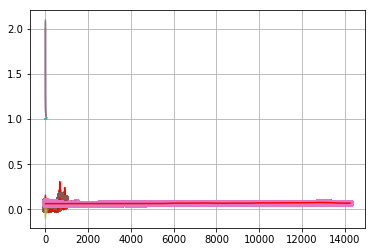

In [29]:
timeframes = ['1d', '1h', '1m']
from math import sqrt

for t in timeframes:
    df = dfs[t]
    volat = sqrt(df['stddev'].max())/2
    print(volat * volat)
    pivots = peak_valley_pivots(df.close.values, volat,-volat)
    # print (pivots)
    df['pivots'] = np.transpose(np.array((pivots)))
    
    max1 = df.high[df['pivots'] == 1].idxmax()

    
    print (max1)
    rest = df[max1+1:]
    # print (rest)
    # print(len(rest))
    max2 = rest.high[df['pivots'] == 1].idxmax()
    # h = df[['pivots'] == 1]
    # max1 = df.iloc[df['pivots'] == 1].index  # find the index of the abs max
    # min1 = df[pivots == -1].min()  # find the index of the abs min
    print (max2)
    # print (min1)
    gentrends(df)
    # print (df.head())

In [3]:
print (df.head())
indices = np.flatnonzero(df['pivots'] == 1)

                       date      open      high       low     close    volume  \
0 2018-04-15 14:04:00+00:00  0.063358  0.063445  0.063358  0.063445  0.793665   
1 2018-04-15 14:05:00+00:00  0.063358  0.063450  0.063358  0.063450  5.290838   
2 2018-04-15 14:06:00+00:00  0.063450  0.063450  0.063358  0.063358  2.998887   
3 2018-04-15 14:07:00+00:00  0.063358  0.063389  0.063300  0.063389  3.859812   
4 2018-04-15 14:08:00+00:00  0.063389  0.063440  0.063389  0.063440  0.157756   

   macd  macdsignal  macdhist  mfi   ...      blower  bb_lowerband  \
0   NaN         NaN       NaN  NaN   ...         NaN           NaN   
1   NaN         NaN       NaN  NaN   ...         NaN           NaN   
2   NaN         NaN       NaN  NaN   ...         NaN           NaN   
3   NaN         NaN       NaN  NaN   ...         NaN           NaN   
4   NaN         NaN       NaN  NaN   ...    0.063416           NaN   

   bb_middleband  bb_upperband  stddev   ha_open  ha_close  buy  sell  pivots  
0           

In [4]:

from math import pow
pow(2,2)

4.0

14236
14000


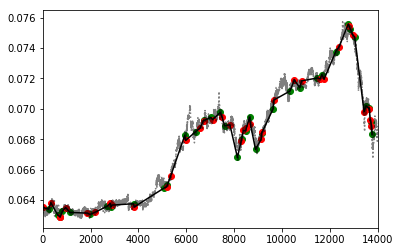

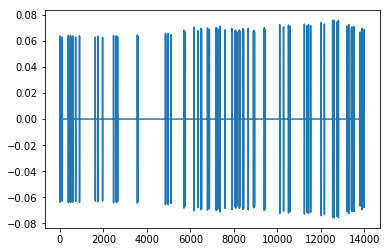

In [27]:

# def parser(x):
# 	return datetime.strptime('190'+x, '%Y-%m')

timeframe = 14000
short_df = df['close'][-timeframe:]
short_pivots = pivots[:timeframe]
def price_pivots (row):
   if row['pivots'] != 0 :
      return row['close']
   else:
      return 0
    
df['pivots_price'] = df.apply(lambda row: price_pivots(row), axis=1)

short_pivots_price = df['pivots_price'][-timeframe:]
print(len(df))
print(len(short_pivots))

plot_pivots(short_df, short_pivots)
# plt.plot(short_pivots_price)
# plt.show()
# plt.plot(short_pivots)
series = short_pivots_price
X = series.values
diff = list()
for i in range(1, len(X)):
	value = X[i] - X[i - 1]
	diff.append(value)
plt.plot(diff)
plt.show()


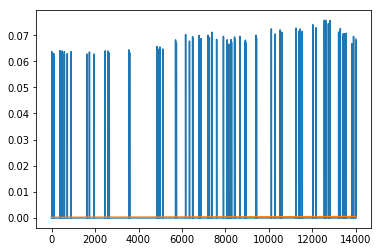

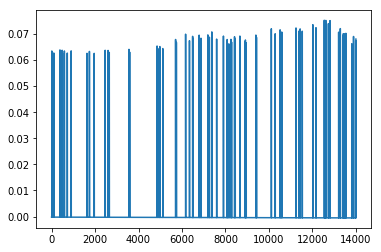

In [28]:
from sklearn.linear_model import LinearRegression

# fit linear model
X = [i for i in range(0, len(series))]
X = np.reshape(X, (len(X), 1))
y = series.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
# plot trend
plt.plot(y)
plt.plot(trend)
plt.show()
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(series))]
# plot detrended
plt.plot(detrended)
plt.show()